# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [1]:
# !pip3 -qq install torch==0.4.1
# !pip3 -qq install bokeh==0.13.0
# !pip3 -qq install gensim==3.6.0
# !pip3 -qq install nltk
# !pip3 -qq install scikit-learn==0.20.2

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor
    
device = torch.device("cuda:0")  
np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [3]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /home/iorana/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/iorana/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Пример размеченного предложения:

In [4]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [5]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [6]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'NUM', 'ADP', 'ADJ', 'PRON', 'PRT', 'NOUN', '.', 'ADV', 'X', 'CONJ', 'VERB', 'DET'}


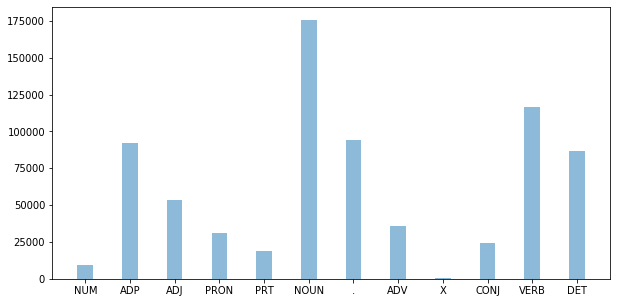

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [8]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [9]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [10]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [11]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [12]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [13]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

**Задание** Реализуйте `LSTMTagger`:

In [14]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, word_emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size = word_emb_dim,
                            hidden_size = lstm_hidden_dim,
                            num_layers = lstm_layers_count)
        self.logits = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeds = self.embedding(inputs)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.logits(lstm_out)
        return tag_space

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [15]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

def calc_accuracy(model, data):
    x, y = data
    prediction = model(x)
    mask = y > 0
    indices = torch.argmax(prediction, dim= -1)
    correct_count = torch.sum(indices[mask] == y[mask])
    sum_count = torch.sum(mask)
    return correct_count.item(), sum_count.item()

In [16]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
loss = criterion(logits.permute(1, 2, 0), y_batch.permute(1, 0))
print(loss)
calc_accuracy(model, (X_batch, y_batch))

tensor(2.5627, grad_fn=<NllLoss2DBackward>)


(8, 92)

**Задание** Вставьте эти вычисление в функцию:

In [17]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss = criterion(logits.permute(1,2,0), y_batch.permute(1,0))
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                cur_correct_count, cur_sum_count = calc_accuracy(model, (X_batch, y_batch))
                correct_count += cur_correct_count
                sum_count += cur_sum_count
                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [18]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind),
    word_emb_dim=100,
    lstm_hidden_dim=128,
    lstm_layers_count=1
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.68740, Accuracy = 78.52%: 100%|██████████| 572/572 [00:04<00:00, 125.63it/s]
[1 / 50]   Val: Loss = 0.35047, Accuracy = 88.34%: 100%|██████████| 13/13 [00:00<00:00, 83.40it/s]
[2 / 50] Train: Loss = 0.27428, Accuracy = 91.12%: 100%|██████████| 572/572 [00:04<00:00, 129.38it/s]
[2 / 50]   Val: Loss = 0.23196, Accuracy = 92.42%: 100%|██████████| 13/13 [00:00<00:00, 82.42it/s]
[3 / 50] Train: Loss = 0.18570, Accuracy = 94.04%: 100%|██████████| 572/572 [00:04<00:00, 128.57it/s]
[3 / 50]   Val: Loss = 0.18658, Accuracy = 93.90%: 100%|██████████| 13/13 [00:00<00:00, 79.27it/s]
[4 / 50] Train: Loss = 0.13897, Accuracy = 95.57%: 100%|██████████| 572/572 [00:04<00:00, 133.44it/s]
[4 / 50]   Val: Loss = 0.16468, Accuracy = 94.70%: 100%|██████████| 13/13 [00:00<00:00, 84.47it/s]
[5 / 50] Train: Loss = 0.10860, Accuracy = 96.54%: 100%|██████████| 572/572 [00:04<00:00, 133.20it/s]
[5 / 50]   Val: Loss = 0.15443, Accuracy = 95.12%: 100%|██████████| 13/13 [00:00<00:00, 82.75i

[41 / 50] Train: Loss = 0.00398, Accuracy = 99.85%: 100%|██████████| 572/572 [00:04<00:00, 131.05it/s] 
[41 / 50]   Val: Loss = 0.34550, Accuracy = 95.28%: 100%|██████████| 13/13 [00:00<00:00, 78.22it/s]
[42 / 50] Train: Loss = 0.00635, Accuracy = 99.85%: 100%|██████████| 572/572 [00:04<00:00, 130.30it/s] 
[42 / 50]   Val: Loss = 0.34083, Accuracy = 95.18%: 100%|██████████| 13/13 [00:00<00:00, 84.47it/s]
[43 / 50] Train: Loss = 0.00475, Accuracy = 99.85%: 100%|██████████| 572/572 [00:04<00:00, 128.47it/s] 
[43 / 50]   Val: Loss = 0.34001, Accuracy = 95.26%: 100%|██████████| 13/13 [00:00<00:00, 82.83it/s]
[44 / 50] Train: Loss = 0.00391, Accuracy = 99.85%: 100%|██████████| 572/572 [00:04<00:00, 127.34it/s] 
[44 / 50]   Val: Loss = 0.34322, Accuracy = 95.28%: 100%|██████████| 13/13 [00:00<00:00, 81.81it/s]
[45 / 50] Train: Loss = 0.00369, Accuracy = 99.85%: 100%|██████████| 572/572 [00:04<00:00, 130.07it/s] 
[45 / 50]   Val: Loss = 0.34402, Accuracy = 95.28%: 100%|██████████| 13/13 [00:0

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [19]:
def check_accuracy_on_test_data(model):
    correct_count = 0
    sum_count = 0
    model.eval()

    test_batch_size = 512

    data = (X_test, y_test)

    for i, (X_batch, y_batch) in enumerate(iterate_batches(data, test_batch_size)):
        X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
        logits = model(X_batch)
        cur_correct_count, cur_sum_count = calc_accuracy(model, (X_batch, y_batch))
        correct_count += cur_correct_count
        sum_count += cur_sum_count
    print('Accuracy on test data: {:.2%}'.format(correct_count/sum_count))

In [20]:
check_accuracy_on_test_data(model)

Accuracy on test data: 95.36%


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [21]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, word_emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size = word_emb_dim,
                            hidden_size = lstm_hidden_dim,
                            num_layers = lstm_layers_count,
                            bidirectional=True)
        self.logits = nn.Linear(2*lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeds = self.embedding(inputs)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.logits(lstm_out)
        return tag_space

In [22]:
model = BiLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind),
    word_emb_dim=100,
    lstm_hidden_dim=128,
    lstm_layers_count=1
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.55826, Accuracy = 82.88%: 100%|██████████| 572/572 [00:06<00:00, 91.25it/s]
[1 / 50]   Val: Loss = 0.27132, Accuracy = 91.28%: 100%|██████████| 13/13 [00:00<00:00, 61.25it/s]
[2 / 50] Train: Loss = 0.20537, Accuracy = 93.68%: 100%|██████████| 572/572 [00:06<00:00, 89.86it/s]
[2 / 50]   Val: Loss = 0.17925, Accuracy = 94.39%: 100%|██████████| 13/13 [00:00<00:00, 59.57it/s]
[3 / 50] Train: Loss = 0.12998, Accuracy = 96.20%: 100%|██████████| 572/572 [00:06<00:00, 94.55it/s]
[3 / 50]   Val: Loss = 0.13946, Accuracy = 95.63%: 100%|██████████| 13/13 [00:00<00:00, 61.02it/s]
[4 / 50] Train: Loss = 0.08859, Accuracy = 97.50%: 100%|██████████| 572/572 [00:06<00:00, 91.69it/s]
[4 / 50]   Val: Loss = 0.12423, Accuracy = 96.16%: 100%|██████████| 13/13 [00:00<00:00, 60.55it/s]
[5 / 50] Train: Loss = 0.06090, Accuracy = 98.37%: 100%|██████████| 572/572 [00:06<00:00, 92.20it/s]
[5 / 50]   Val: Loss = 0.11788, Accuracy = 96.50%: 100%|██████████| 13/13 [00:00<00:00, 60.87it/s]


[41 / 50] Train: Loss = 0.00005, Accuracy = 100.00%: 100%|██████████| 572/572 [00:06<00:00, 90.63it/s]
[41 / 50]   Val: Loss = 0.23828, Accuracy = 96.89%: 100%|██████████| 13/13 [00:00<00:00, 57.69it/s]
[42 / 50] Train: Loss = 0.00005, Accuracy = 100.00%: 100%|██████████| 572/572 [00:06<00:00, 89.91it/s]
[42 / 50]   Val: Loss = 0.23912, Accuracy = 96.89%: 100%|██████████| 13/13 [00:00<00:00, 59.97it/s]
[43 / 50] Train: Loss = 0.00004, Accuracy = 100.00%: 100%|██████████| 572/572 [00:06<00:00, 89.53it/s]
[43 / 50]   Val: Loss = 0.24211, Accuracy = 96.90%: 100%|██████████| 13/13 [00:00<00:00, 59.05it/s]
[44 / 50] Train: Loss = 0.00004, Accuracy = 100.00%: 100%|██████████| 572/572 [00:06<00:00, 90.88it/s]
[44 / 50]   Val: Loss = 0.24173, Accuracy = 96.91%: 100%|██████████| 13/13 [00:00<00:00, 60.95it/s]
[45 / 50] Train: Loss = 0.00004, Accuracy = 100.00%: 100%|██████████| 572/572 [00:06<00:00, 92.38it/s]
[45 / 50]   Val: Loss = 0.24435, Accuracy = 96.91%: 100%|██████████| 13/13 [00:00<00:

In [23]:
check_accuracy_on_test_data(model)

Accuracy on test data: 96.87%


### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [24]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

Построим подматрицу для слов из нашей тренировочной выборки:

In [25]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [26]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self.embedding = nn.Embedding.from_pretrained(torch.Tensor(embeddings), padding_idx=0)
        self.lstm = nn.LSTM(input_size = 100,
                            hidden_size = lstm_hidden_dim,
                            num_layers = lstm_layers_count,
                            bidirectional=True)
        self.logits = nn.Linear(2*lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeds = self.embedding(inputs)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.logits(lstm_out)
        return tag_space

In [27]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind),
    lstm_hidden_dim=64,
    lstm_layers_count=2
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=13,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 13] Train: Loss = 0.53802, Accuracy = 83.87%: 100%|██████████| 572/572 [00:10<00:00, 54.83it/s]
[1 / 13]   Val: Loss = 0.19900, Accuracy = 93.97%: 100%|██████████| 13/13 [00:00<00:00, 55.36it/s]
[2 / 13] Train: Loss = 0.13384, Accuracy = 96.07%: 100%|██████████| 572/572 [00:10<00:00, 54.45it/s]
[2 / 13]   Val: Loss = 0.12923, Accuracy = 96.02%: 100%|██████████| 13/13 [00:00<00:00, 60.06it/s]
[3 / 13] Train: Loss = 0.09564, Accuracy = 97.15%: 100%|██████████| 572/572 [00:10<00:00, 54.78it/s]
[3 / 13]   Val: Loss = 0.10976, Accuracy = 96.60%: 100%|██████████| 13/13 [00:00<00:00, 55.01it/s]
[4 / 13] Train: Loss = 0.07929, Accuracy = 97.61%: 100%|██████████| 572/572 [00:09<00:00, 57.27it/s] 
[4 / 13]   Val: Loss = 0.10054, Accuracy = 96.81%: 100%|██████████| 13/13 [00:00<00:00, 56.65it/s]
[5 / 13] Train: Loss = 0.06960, Accuracy = 97.90%: 100%|██████████| 572/572 [00:10<00:00, 54.81it/s]
[5 / 13]   Val: Loss = 0.09963, Accuracy = 96.81%: 100%|██████████| 13/13 [00:00<00:00, 53.98it/s]

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [28]:
check_accuracy_on_test_data(model)

Accuracy on test data: 97.17%
